In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
import torch.optim as optim
import torchmetrics

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        #T.RandomHorizontalFlip(),
        #T.RandomRotation(23),
        #T.RandomPerspective(),
        T.ToTensor() # автоматически интервал пикселей будет 0-1
    ]
)

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
    './data/archive_blood/TRAIN',
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    './data/archive_blood//TEST',
    transform=trnsfrms
)

In [5]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}

In [6]:
idx2class

{0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

In [7]:
df_labels = pd.DataFrame.from_dict(idx2class, orient='index')
df_labels

,0
0,EOSINOPHIL
1,LYMPHOCYTE
2,MONOCYTE
3,NEUTROPHIL


In [8]:
df_labels.to_csv('./models/model_blood/data_labels.csv', index=False, encoding='utf-8')

In [9]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True)

In [10]:
if torch.cuda.is_available():
    print("CUDA доступна!")
    device = torch.device("cuda")
else:
    print("CUDA недоступна. Вычисления будут выполняться на CPU.")
    device = torch.device("cpu")

CUDA доступна!


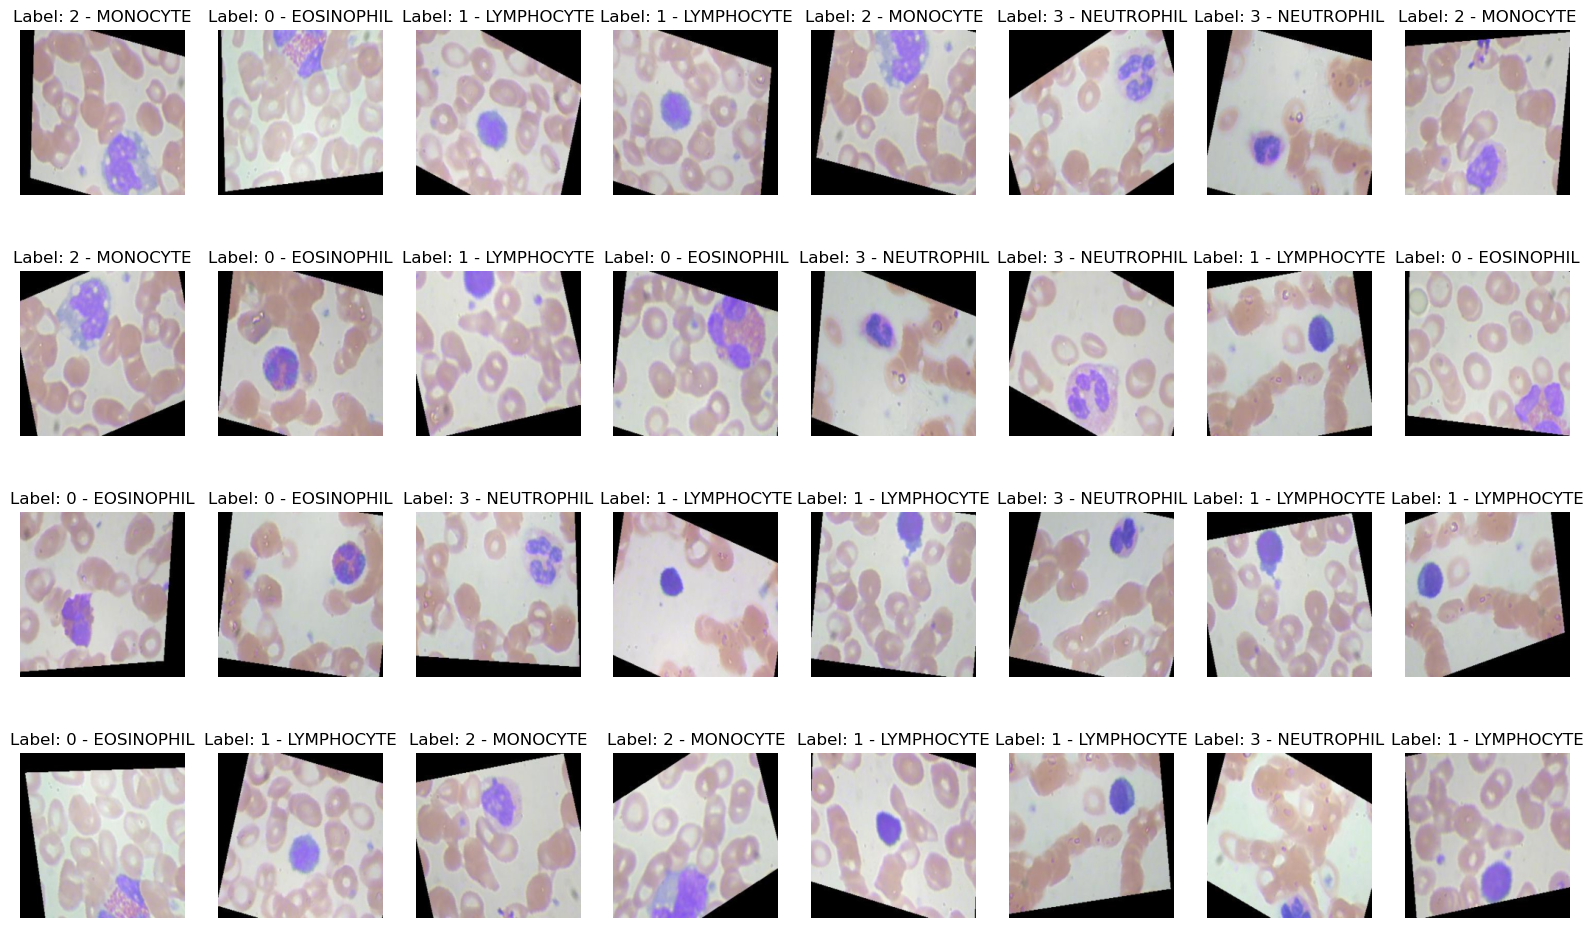

In [11]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch

for i, plot in enumerate(ax):
    label_index = test_targets[i].item()
    plot.set_title(f'Label: {label_index} - {valid_loader.dataset.classes[label_index]}')

    # Проверяем количество каналов
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    elif test_samples[i].shape[0] == 1:  # Если 1 канал (оттенки серого)
        img = test_samples[i][0, :, :]  # Оставляем как есть
    else:
        raise ValueError("Неизвестное количество каналов")

    plot.imshow(img.cpu())  # Используем imshow() для цветных изображений
    plot.axis('off')

plt.show()

In [12]:
def fit(
        model: torch.nn.Module,
        n_epochs: int,
        optimizer: torch.optim.Optimizer,
        criterion,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        ) -> tuple[list, ...]:

    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(device)  # Инициализируем torchmetrics.Accuracy

    train_losses = []
    valid_losses = []
    train_metrics = []
    valid_metrics = []
    time_metrics = []

    for epoch in range(n_epochs):
        start = datetime.datetime.now()
        
        model.train()

        train_loss_epoch = []
        train_metric_epoch = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)  # Используем переданный criterion

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)  # Используем torchmetrics.Accuracy
            train_loss_epoch.append(loss.item())
            train_metric_epoch.append(acc.item())

        model.eval()

        valid_loss_epoch = []
        valid_metric_epoch = []

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)  # Получаем выходы модели

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            valid_loss_epoch.append(loss.item())
            valid_metric_epoch.append(acc.item())

        epoch_train_loss = np.mean(train_loss_epoch)
        epoch_train_metric = np.mean(train_metric_epoch)

        epoch_valid_loss = np.mean(valid_loss_epoch)
        epoch_valid_metric = np.mean(valid_metric_epoch)

        time = (datetime.datetime.now() - start).total_seconds()
        time_metrics.append(round(time))
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        train_metrics.append(epoch_train_metric)
        valid_metrics.append(epoch_valid_metric)
        

        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_metric:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {epoch_valid_metric:.4f}")

        
    return train_losses, valid_losses, train_metrics, valid_metrics, time_metrics

In [13]:
from torchvision.models import resnet50, ResNet50_Weights
model_lrs = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

In [14]:
tu.get_model_summary(model_lrs.to(device), test_samples[1].unsqueeze(0).to(device))

Layer                                         Kernel              Output          Params           FLOPs
0_conv1                                      [3, 64, 7, 7]   [1, 64, 112, 112]       9,408   118,013,952
1_bn1                                                 [64]   [1, 64, 112, 112]         128     3,211,264
2_relu                                                   -   [1, 64, 112, 112]           0             0
3_maxpool                                                -     [1, 64, 56, 56]           0             0
4_layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [1, 64, 56, 56]       4,096    12,845,056
5_layer1.0.BatchNorm2d_bn1                            [64]     [1, 64, 56, 56]         128       802,816
6_layer1.0.ReLU_relu                                     -     [1, 64, 56, 56]           0             0
7_layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
8_layer1.0.BatchNorm2d_bn2                            [

In [15]:
display(model_lrs.fc)
model_lrs.fc = nn.Linear(2048, 4)
display(model_lrs.fc)

Linear(in_features=2048, out_features=1000, bias=True)

Linear(in_features=2048, out_features=4, bias=True)

In [16]:
for param in model_lrs.parameters():
    param.requires_grad = False

In [18]:
for name, param in model_lrs.named_parameters():
#    if param.requires_grad:
    print(f"Тренируемый параметр: {name} - {param.requires_grad}")

Тренируемый параметр: conv1.weight - False
Тренируемый параметр: bn1.weight - False
Тренируемый параметр: bn1.bias - False
Тренируемый параметр: layer1.0.conv1.weight - False
Тренируемый параметр: layer1.0.bn1.weight - False
Тренируемый параметр: layer1.0.bn1.bias - False
Тренируемый параметр: layer1.0.conv2.weight - False
Тренируемый параметр: layer1.0.bn2.weight - False
Тренируемый параметр: layer1.0.bn2.bias - False
Тренируемый параметр: layer1.0.conv3.weight - False
Тренируемый параметр: layer1.0.bn3.weight - False
Тренируемый параметр: layer1.0.bn3.bias - False
Тренируемый параметр: layer1.0.downsample.0.weight - False
Тренируемый параметр: layer1.0.downsample.1.weight - False
Тренируемый параметр: layer1.0.downsample.1.bias - False
Тренируемый параметр: layer1.1.conv1.weight - False
Тренируемый параметр: layer1.1.bn1.weight - False
Тренируемый параметр: layer1.1.bn1.bias - False
Тренируемый параметр: layer1.1.conv2.weight - False
Тренируемый параметр: layer1.1.bn2.weight - False


In [19]:
model_lrs.layer4[2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [17]:
model_lrs.layer4[2]

model_lrs.fc.weight.requires_grad = True
model_lrs.fc.bias.requires_grad = True

In [18]:
for param in model_lrs.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [19]:
criterion_lrs = nn.CrossEntropyLoss()
optimizer_lrs = optim.NAdam(model_lrs.parameters())

In [20]:
model_lrs.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
history = None

In [22]:
torch.cuda.empty_cache()

In [23]:
%%time
start = datetime.datetime.now()
print('Время старта: ' + str(start))

model_lrs.to(device)

model_data = fit(n_epochs=30, model=model_lrs, optimizer=optimizer_lrs, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion_lrs)

finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# вычитаем время старта из времени окончания
print('Время : ' + str(finish - start))

Время старта: 2025-02-07 14:39:57.645082
Epoch 1/30: Train Loss: 1.2402, Train Accuracy: 0.5163, Valid Loss: 1.2921, Valid Accuracy: 0.3865
Epoch 2/30: Train Loss: 1.0301, Train Accuracy: 0.6628, Valid Loss: 1.1679, Valid Accuracy: 0.5210
Epoch 3/30: Train Loss: 0.9031, Train Accuracy: 0.7298, Valid Loss: 1.1104, Valid Accuracy: 0.5539
Epoch 4/30: Train Loss: 0.8100, Train Accuracy: 0.7711, Valid Loss: 1.0839, Valid Accuracy: 0.5650
Epoch 5/30: Train Loss: 0.7399, Train Accuracy: 0.8011, Valid Loss: 1.0563, Valid Accuracy: 0.5839
Epoch 6/30: Train Loss: 0.6832, Train Accuracy: 0.8219, Valid Loss: 1.0481, Valid Accuracy: 0.5867
Epoch 7/30: Train Loss: 0.6375, Train Accuracy: 0.8358, Valid Loss: 1.0300, Valid Accuracy: 0.5907
Epoch 8/30: Train Loss: 0.5996, Train Accuracy: 0.8477, Valid Loss: 1.0259, Valid Accuracy: 0.5925
Epoch 9/30: Train Loss: 0.5650, Train Accuracy: 0.8601, Valid Loss: 1.0051, Valid Accuracy: 0.6042
Epoch 10/30: Train Loss: 0.5379, Train Accuracy: 0.8639, Valid Loss:

In [35]:
torch.save(model_lrs, './models/model_blood/model_50_blood.pth')

In [25]:
#torch.save(model_lrs.state_dict(), './models/model_sport/sport_weights.pth')

In [26]:
train_losses, valid_losses, train_metric, valid_metric, time = model_data

In [36]:
data_metrics = np.array([
    train_losses, valid_losses, train_metric, valid_metric, time
])

df = pd.DataFrame(data_metrics.T, columns=['train_losses', 'valid_losses', 'train_metric', 'valid_metric', 'time'])
df

,train_losses,valid_losses,train_metric,valid_metric,time
0,1.240172,1.292100,0.516288,0.386456,38.0
1,1.030074,1.167903,0.662780,0.520981,38.0
2,0.903078,1.110359,0.729754,0.553859,38.0
3,0.809960,1.083910,0.771146,0.564959,38.0
4,0.739922,1.056259,0.801096,0.583935,38.0
5,0.683156,1.048120,0.821897,0.586672,38.0
6,0.637457,1.030042,0.835783,0.590740,38.0
7,0.599565,1.025870,0.847715,0.592531,38.0
8,0.565033,1.005117,0.860114,0.604246,38.0
9,0.537929,1.001139,0.863877,0.608079,38.0


In [34]:
df.to_csv('./models/model_blood/data_50_blood.csv', index=False, encoding='utf-8')

(0.0, 1.0293948580057193)

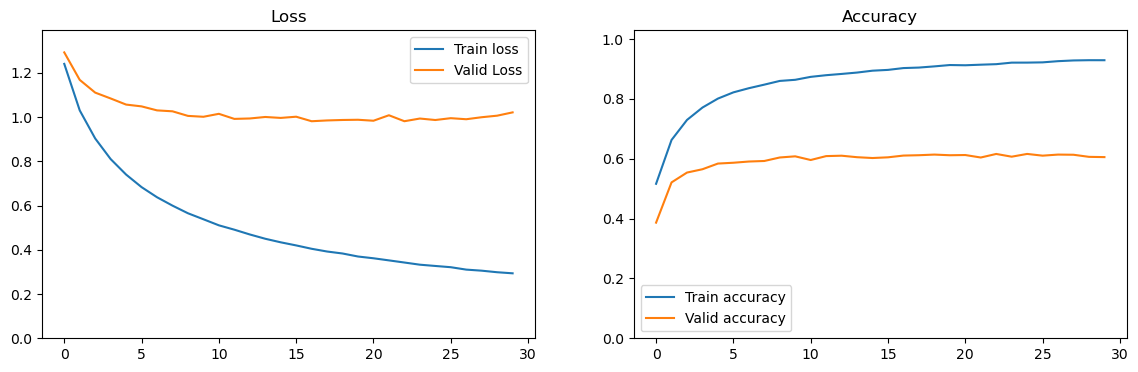

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(train_losses, label='Train loss')
ax[0].plot(valid_losses, label='Valid Loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_ylim((0, max(train_losses+valid_losses)+.1))

ax[1].plot(train_metric, label='Train accuracy')
ax[1].plot(valid_metric, label='Valid accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_ylim((0, max(train_metric+valid_metric)+.1))

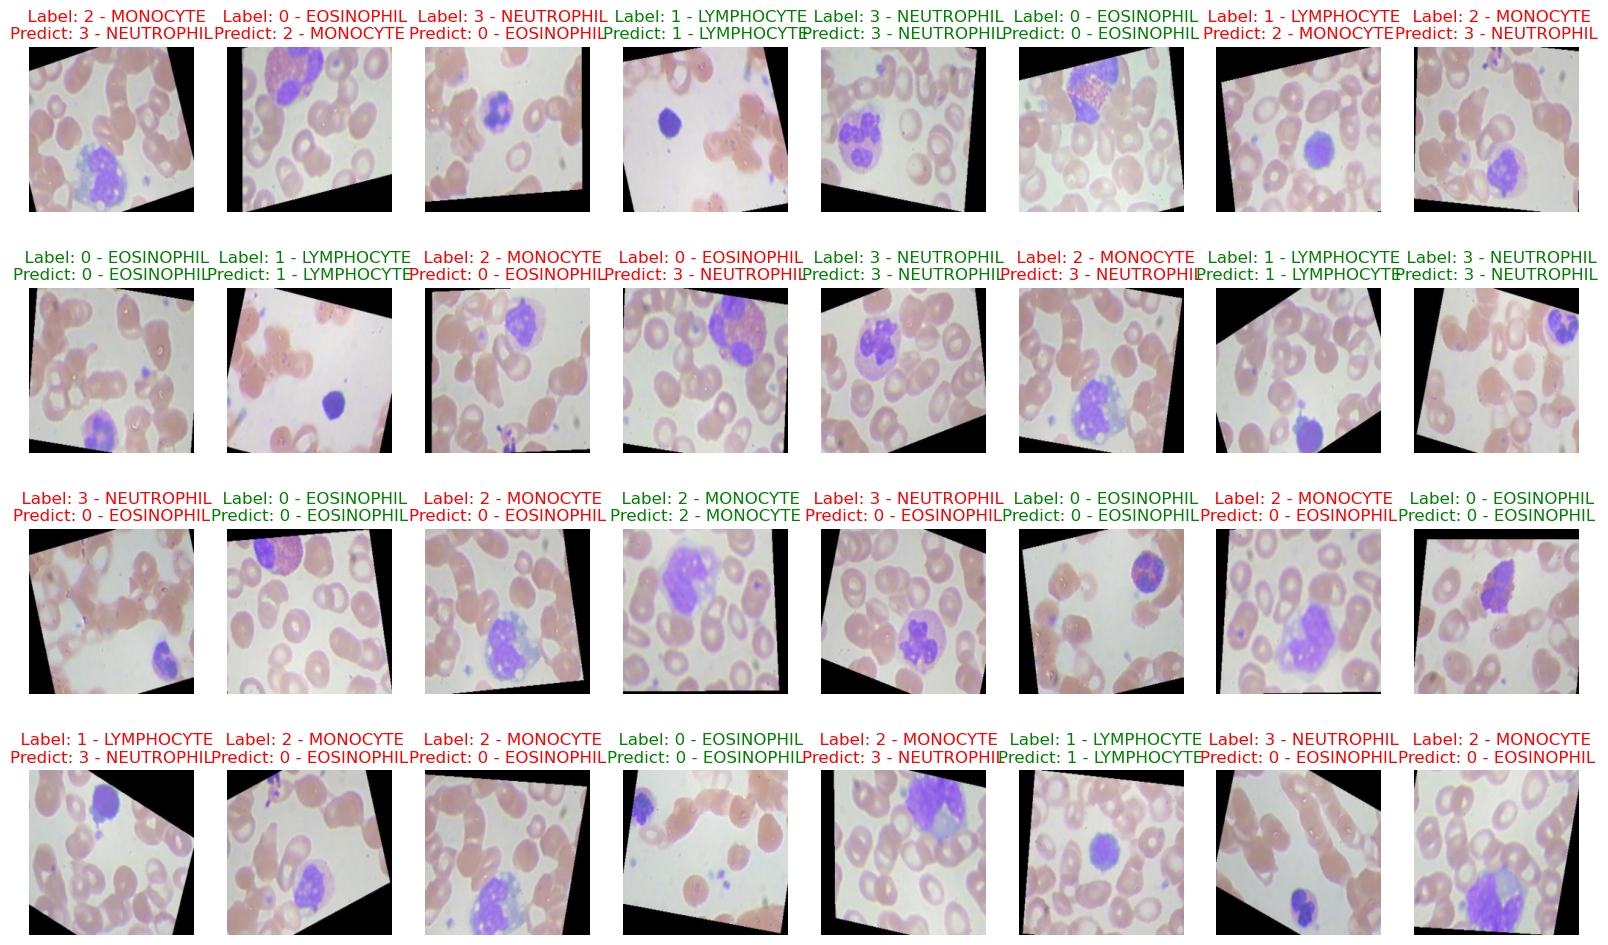

In [30]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten() # переводим в одномерный массив
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch
test_samples = test_samples.to(device)
for i, plot in enumerate(ax):
    label_index = test_targets[i].item()  # Получаем индекс метки из тестового набора
    y_pred = torch.argmax(model_lrs(test_samples[i].unsqueeze(0)))
    y_pred = y_pred.cpu().detach().numpy()
    color = 'r' if y_pred != label_index else 'g'
    plot.set_title(f'  Label: {label_index} - {train_loader.dataset.classes[label_index]}\n'
                   f'Predict: {y_pred} - {train_loader.dataset.classes[y_pred]}', color=color)
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    plot.imshow(img.cpu())#plot.matshow(test_samples[i][0, :, :].cpu().detach().numpy(), cmap='gray')
    plot.axis('off')

In [31]:
def get_prediction(path: str, model) -> str:
    resize = T.Resize((224, 224))
    img = resize(io.read_image(path)/255)
    #plt.imshow(torch.permute(img, (1, 2, 0)))
    with torch.inference_mode():
        pred_class = torch.argmax(model(img.unsqueeze(0).to(device))).item()
    #plt.axis('off')
    #plt.title(idx2class[pred_class]);
    return pred_class

In [32]:
get_prediction("download.jpeg", model_lrs)

0

In [33]:
def get_prediction(path: str, model) -> str:
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Изменение размера изображения
        transforms.ToTensor() # Преобразование в тензор
    ])
    input_tensor = transform(image)
    with torch.inference_mode():
        pred_class = torch.argmax(model(input_tensor.unsqueeze(0).to('cpu'))).item()
    return pred_class